In [1]:
%cd ..

c:\Master\GI\riemannian_geometry


In [4]:
import numpy as np
import glob
import torch
import torch.nn as nn
import os

from src.config.paths import INTERIM_DIR, HDM05_WINDOWS_DIR, HDM05_SPD_DIR

from src.data.datasets import HDM05SPDDataset
from src.data.data_loader import get_dataloaders
from src.models.spdnet import BiMapLayer, SPDNet, StiefelSGD
from src.training.utils import get_device, set_seed

In [3]:
def get_data(dir, all = None):
    # Cambia esta ruta a donde estén tus .npz o .pt
    files = sorted(glob.glob(str(dir / "*.npz")))

    print("Total matrices =", len(files))

    spds = []

    for i in range(len(files)):
        # Carga una SPD al azar
        sample = np.load(files[i])
        # Intenta detectar el nombre correcto del array dentro del NPZ
        # print("Keys in npz:", sample.files)

        X = sample[sample.files[0]]  # la matriz SPD
        # print("Shape:", X.shape)

        SPD = torch.tensor(X, dtype=torch.float64)

        spds.append(SPD)

        if not all:
            break
    return spds

In [12]:
def analyze_spd(M):
    # print("Matrix shape:", M.shape)
    if M.shape[0] != M.shape[1]:
        raise ValueError("La matriz no es cuadrada")

    # simetría
    sym = torch.norm(M - M.T)
    # print("Symmetry error:", sym.item())

    # eigenvalores
    eigvals = torch.linalg.eigvalsh(M)
    # print("Eigenvalues:", eigvals)

    # print("Min eigenvalue:", eigvals.min().item())
    # print("Max eigenvalue:", eigvals.max().item())

    # cond = eigvals.max() / eigvals.min() if eigvals.min() > 0 else float("inf")
    # print("Condition number:", cond)

    if eigvals.min() <= 0:
        print("!!!!!!!")
        print("NO SPD — hay eigenvalores negativos o cero")
    elif eigvals.min() < 1e-6:
        print("SPD casi singular (min eigenvalue < 1e-6)")
    else:
        print("SPD correcta")

In [9]:
interim = get_data(INTERIM_DIR)
# 401 frames en el video
# 31 joints
# 3 dimensiones

Total matrices = 2343


In [6]:
windows = get_data(HDM05_WINDOWS_DIR)
# numero de ventanas generadas
# 32 es el tamaño de las ventanas
# 93 = 31*3

Total matrices = 2338


In [13]:
spds = get_data(HDM05_SPD_DIR, True)
# 93*93 matrices simetricas
for SPD in spds[:2]:
    for i in range(SPD.shape[0]):
        M = torch.tensor(SPD[i], dtype=torch.float64)
        analyze_spd(M)

Total matrices = 2338
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta
SPD correcta


C:\Users\nleye\AppData\Local\Temp\ipykernel_20432\124580107.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  M = torch.tensor(SPD[i], dtype=torch.float64)


-----

In [8]:
from src.data.hdm05_loader import list_c3d_files
from src.data.preprocessing import compute_common_markers, build_identity_joint_mapping

from src.config.paths import HDM05_CUTS_C3D_DIR

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ezc3d import c3d

In [41]:
files = list_c3d_files(use_cuts=True, pattern="*.C3D")

print(len(files))

per_file, common_markers = compute_common_markers(files)
joint_mapping = build_identity_joint_mapping(common_markers)

joint_mapping

data\HDM05\cuts
2343


{'C7': 'C7',
 'CLAV': 'CLAV',
 'LFHD': 'LFHD',
 'RBAC': 'RBAC',
 'T10': 'T10',
 'STRN': 'STRN',
 'LSHO': 'LSHO',
 'LELB': 'LELB',
 'LFRM': 'LFRM',
 'LWRA': 'LWRA',
 'LWRB': 'LWRB',
 'LFIN': 'LFIN',
 'RSHO': 'RSHO',
 'RELB': 'RELB',
 'RFRM': 'RFRM',
 'RWRA': 'RWRA',
 'RWRB': 'RWRB',
 'LBWT': 'LBWT',
 'LFWT': 'LFWT',
 'LKNE': 'LKNE',
 'LANK': 'LANK',
 'LHEE': 'LHEE',
 'LTOE': 'LTOE',
 'LMT5': 'LMT5',
 'RBWT': 'RBWT',
 'RFWT': 'RFWT',
 'RKNE': 'RKNE',
 'RANK': 'RANK',
 'RHEE': 'RHEE',
 'RTOE': 'RTOE',
 'RMT5': 'RMT5'}

In [42]:
SKELETON_CONNECTIONS = [
    # Tronco
    ("C7", "T10"),
    ("C7", "CLAV"),
    ("CLAV", "STRN"),
    ("T10", "LBWT"),
    ("LBWT", "LFWT"),
    ("LBWT", "RBWT"),
    ("LFWT", "RFWT"),

    # Cabeza
    ("C7", "LFHD"),
    ("C7", "RBAC"),

    # Brazo izquierdo
    ("CLAV", "LSHO"),
    ("LSHO", "LELB"),
    ("LELB", "LFRM"),
    ("LFRM", "LWRA"),
    ("LWRA", "LWRB"),
    ("LWRB", "LFIN"),

    # Brazo derecho
    ("CLAV", "RSHO"),
    ("RSHO", "RELB"),
    ("RELB", "RFRM"),
    ("RFRM", "RWRA"),
    ("RWRA", "RWRB"),

    # Pierna izquierda
    ("LFWT", "LKNE"),
    ("LKNE", "LANK"),
    ("LANK", "LHEE"),
    ("LANK", "LTOE"),
    ("LANK", "LMT5"),

    # Pierna derecha
    ("RFWT", "RKNE"),
    ("RKNE", "RANK"),
    ("RANK", "RHEE"),
    ("RANK", "RTOE"),
    ("RANK", "RMT5"),
]


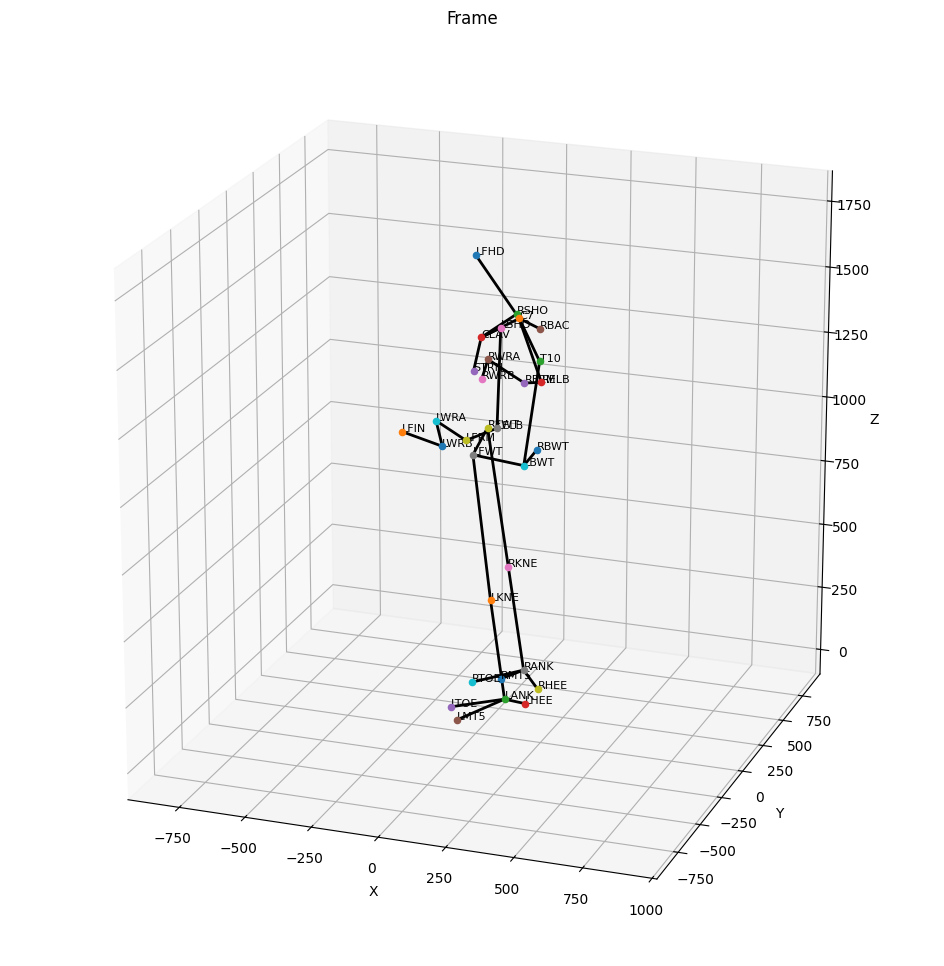

In [57]:
def set_axes_equal(ax):
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    y_range = abs(y_limits[1] - y_limits[0])
    z_range = abs(z_limits[1] - z_limits[0])

    max_range = max([x_range, y_range, z_range]) / 2

    mid_x = np.mean(x_limits)
    mid_y = np.mean(y_limits)
    mid_z = np.mean(z_limits)

    ax.set_xlim3d([mid_x - max_range, mid_x + max_range])
    ax.set_ylim3d([mid_y - max_range, mid_y + max_range])
    ax.set_zlim3d([mid_z - max_range, mid_z + max_range])


def plot_skeleton_frame(marker_dict, ax, title="Frame"):
    xs, ys, zs = [], [], []
    for k, v in marker_dict.items():
        xs.append(v[0]); ys.append(v[1]); zs.append(v[2])
        ax.scatter(v[0], v[1], v[2], s=20)
        ax.text(v[0], v[1], v[2], k, fontsize=8)

    # Dibujar conexiones
    for a, b in SKELETON_CONNECTIONS:
        if a in marker_dict and b in marker_dict:
            p1 = marker_dict[a]
            p2 = marker_dict[b]
            ax.plot(
                [p1[0], p2[0]],
                [p1[1], p2[1]],
                [p1[2], p2[2]],
                linewidth=2,
                color="black"
            )

    ax.set_box_aspect([1, 1, 1])
    set_axes_equal(ax)

    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.view_init(elev=20, azim=-70)

def clean_label(label):
    # Quitar espacios
    label = label.strip()

    # Eliminar marcadores fantasma tipo "*0", "*1"... 
    if label.startswith("*"):
        return None

    # Quitar prefijo 'Bastian:' u otros parecidos
    if ":" in label:
        label = label.split(":")[1]

    return label

def visualize_example(c3d_path, joint_mapping, return_dict=False):
    import numpy as np
    from ezc3d import c3d

    data = c3d(str(c3d_path))
    points = data["data"]["points"]  
    raw_labels = data["parameters"]["POINT"]["LABELS"]["value"]

    labels = [clean_label(l) for l in raw_labels]

    frame = 0

    coords = {}
    for idx, label in enumerate(labels):
        if label is None:
            continue
        if label in joint_mapping:
            xyz = points[:3, idx, frame]
            if not np.any(np.isnan(xyz)):
                coords[label] = xyz

    mapped = {joint_mapping[k]: v for k, v in coords.items()}

    if return_dict:
        return mapped

    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection="3d")
    plot_skeleton_frame(mapped, ax)
    plt.show()




# Visualizamos el primer archivo
example = files[4]
visualize_example(example, joint_mapping)


AttributeError: 'FigureCanvasAgg' object has no attribute 'tostring_rgb'

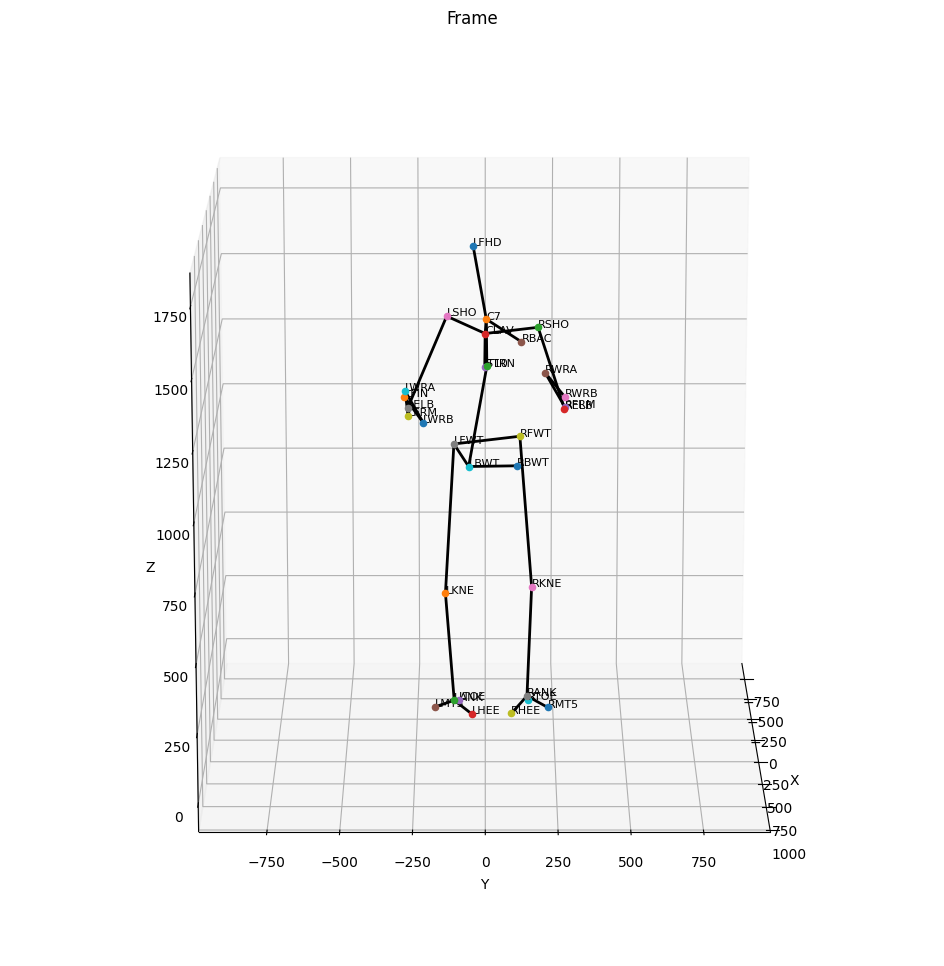

In [58]:
import matplotlib.pyplot as plt
import imageio
import numpy as np

def render_rotation_frames(marker_dict, output_gif="rotation.gif",
                           n_frames=60, elev=10):
    """
    Renderiza el esqueleto rotando alrededor del eje Y.
    - n_frames: número de ángulos en la rotación
    - elev: altura (elevación) constante de la cámara
    """
    frames = []

    for i in range(n_frames):
        fig = plt.figure(figsize=(12,12))
        ax = fig.add_subplot(111, projection="3d")

        # ángulo de rotación (0 a 360 grados)
        azim = (i / n_frames) * 360

        # Plot del esqueleto
        plot_skeleton_frame(marker_dict, ax)

        # Cámara fija en elevación, girando solo alrededor de Y
        ax.view_init(elev=elev, azim=azim)

        # Guardar imagen temporalmente
        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(img)

        plt.close(fig)

    # Crear GIF
    imageio.mimsave(output_gif, frames, fps=30)
    print(f"GIF guardado como {output_gif}")

# Usamos el mismo código que ya tienes para obtener marker_dict
example = files[4]
marker_dict = visualize_example(example, joint_mapping, return_dict=True)

render_rotation_frames(marker_dict, output_gif="skeleton_rotation.gif",
                       n_frames=60, elev=15)



In [61]:
import matplotlib.pyplot as plt
import imageio
import numpy as np

def render_rotation_frames(marker_dict, output_gif="rotation.gif",
                           n_frames=60, elev=10):
    frames = []

    for i in range(n_frames):
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(111, projection="3d")

        # Ángulo de rotación
        azim = (i / n_frames) * 360

        # Dibujar esqueleto
        plot_skeleton_frame(marker_dict, ax)

        # Cámara: rota en azimut, elevación fija
        ax.view_init(elev=elev, azim=azim)

        # Obtener imagen del canvas (compatible con todos los backends)
        fig.canvas.draw()
        renderer = fig.canvas.get_renderer()
        img = np.frombuffer(renderer.buffer_rgba(), dtype=np.uint8)
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        img = img[:, :, :3]  # quitar alpha

        frames.append(img)

        plt.close(fig)

    # Guardar GIF
    imageio.mimsave(output_gif, frames, fps=10)   # va 3x más lento

    print(f"GIF guardado como {output_gif}")

# Usamos el mismo código que ya tienes para obtener marker_dict
example = files[4]
marker_dict = visualize_example(example, joint_mapping, return_dict=True)

render_rotation_frames(marker_dict, output_gif="skeleton_rotation.gif",
                       n_frames=60, elev=15)


GIF guardado como skeleton_rotation.gif
